In [31]:
  %pip install fancy_einsum
  %pip install einops

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:
import os
# Set environment variables
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [33]:
import einops
import datasets
import transformers
from fancy_einsum import einsum
import torch
import torch.nn as nn
import numpy as np
import math
import tqdm.auto as tqdm
import torch.nn.functional as F

size of the vector used to represent each token or position in the model=768(dim_model)

The size of the vocabulary = 50257

The maximum context window size=1024 (n_ctx)

The dimensionality of the model's attention heads=dim_model/12=64:

The dimensionality of the intermediate layer in the feedforward neural network within the transformer block=3072(dim_mlp = 4*dim_model=3072 )

The total number of transformer layers in the model=12

The number of attention heads in the model=12

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
class Configuration:
    def __init__(self, dim_model=768, debug=True, layer_norm_eps=1e-5,
                 dim_vocab=50257, init_range=0.02, n_ctx=1024,
                 dim_head=64, dim_mlp=3072, n_heads=12, n_layers=12):
        self.dim_model = dim_model
        self.debug = debug
        self.layer_norm_eps = layer_norm_eps
        self.dim_vocab = dim_vocab
        self.init_range = init_range
        self.n_ctx = n_ctx
        self.dim_head = dim_head
        self.dim_mlp = dim_mlp
        self.n_heads = n_heads
        self.n_layers = n_layers


    def __repr__(self):
        return (f"Config(dim_model={self.dim_model}, debug={self.debug}, "
                f"layer_norm_eps={self.layer_norm_eps}, dim_vocab={self.dim_vocab}, "
                f"init_range={self.init_range}, n_ctx={self.n_ctx}, "
                f"d_head={self.dim_head}, dim_mlp={self.dim_mlp}, n_heads={self.n_heads}, "
                f"n_layers={self.n_layers})")


cfg = Configuration()
print(cfg)

Config(dim_model=768, debug=True, layer_norm_eps=1e-05, dim_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, dim_mlp=3072, n_heads=12, n_layers=12)


In [36]:
class LayerNoralization(nn.Module):
    def __init__(self, cfg):
        super(LayerNoralization, self).__init__()
        self.cfg = cfg
        self.w = nn.Parameter(torch.ones(cfg.dim_model))
        self.b = nn.Parameter(torch.zeros(cfg.dim_model))

    def forward(self, residual):
        device = residual.device  # Get the device of the input tensor

        # Move parameters to the same device as the input tensor
        w = self.w.to(device)
        b = self.b.to(device)

        # Calculate mean and variance along the d_model dimension
        mean = torch.mean(residual, dim=-1, keepdim=True)  # Shape: [batch, position, 1]
        variance = torch.mean((residual - mean) ** 2, dim=-1, keepdim=True)  # Shape: [batch, position, 1]

        # Calculate scale and normalize the residual
        scale = torch.sqrt(variance + self.cfg.layer_norm_eps)
        normalized = (residual - mean) / scale  # Normalization

        # Apply learned parameters (with moved tensors)
        normalized = normalized * w + b

        return normalized


In [37]:
class Embed(nn.Module):
    def __init__(self, cfg):
        super(Embed, self).__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(torch.empty((cfg.dim_vocab, cfg.dim_model))) # learnable parameter matrix representing token embeddings.
        nn.init.normal_(self.W_E, std=self.cfg.init_range)  #initializes the values of W_E using a normal distribution

    def forward(self, tokens):
        # tokens: [batch, position]
        if self.cfg.debug:
            print("Tokens:", tokens.shape)

        # Using indexing to gather embeddings
        embed = self.W_E[tokens, :]  # [batch, position, d_model] embeddings for each token index in the input tensor

        if self.cfg.debug:
            print("Embeddings:", embed.shape)

        return embed

**positional encoding describes the location of each  entity in the sequence .so that each position will be assigned with unique representation.
why we need this? we can use index if you want unique representatioin ....we avoid using index because it does not convey any information aboubt the words meaning...and another reason is for not using index for this representation because let us say 3 letter word aka....after normalising a corresponds to a-->0,k-->0.66,a-->0.33 now take (akashp) after normalising akashp will be ....a-->0,k-->0.2,a-->0.4,s-->0.6,h-->0.8,p-->1 ....so we cannot use index for this purpose we needed a unique representation to overcome this probelm i.e., positional Embedding

so how does positional encoding work ?**
[https://drive.google.com/file/d/17fcTdO2Z9lHfhZpg3EprD-4I_s9ihbbB/view?usp=sharing](http://)




In [38]:
class PositionalEmbedding(nn.Module):
    def __init__(self, cfg):
        super(PositionalEmbedding, self).__init__()
        self.cfg = cfg
        # Initialize a learnable positional embedding parameter
        self.W_pos = nn.Parameter(torch.empty((cfg.n_ctx, cfg.dim_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(self, tokens):
        # tokens: [batch, position]
        if self.cfg.debug:
            print("Tokens:", tokens.shape)

        # Extract positional embeddings for the given positions
        pos_embed = self.W_pos[:tokens.size(1), :]  # [position, d_model]

        # Repeat the positional embeddings for each batch
        pos_embed = pos_embed.unsqueeze(0).expand(tokens.size(0), -1, -1)

        if self.cfg.debug:
            print("pos_embed:", pos_embed.shape)

        return pos_embed

In [39]:
# print(torch.cuda.is_available())
# print(torch.cuda.memory_summary(device=torch.cuda.current_device()))


****self-attention  
softmax(query*key.T/sqrt(d)) ---->Q.KT gives matrix of alignment scores then alignment matrix(similar waords have high value)is than scaled with key vector dimenssion
scaled scores are converted to weights using softmax 

reason for providing mask is so that it will only see the past not the future(i am akash)....model will only know till i am ak...next word it will try to predict on the base of past words used ****

In [40]:
# self.IGNORE = torch.tensor(-1e5, dtype=torch.float32, device="cuda")

class SelfAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        self.W_Q = nn.Parameter(torch.randn(cfg.n_heads, cfg.dim_model, cfg.dim_head) * self.cfg.init_range)

        self.b_Q = nn.Parameter(torch.zeros((cfg.n_heads, cfg.dim_head)))

        self.W_K = nn.Parameter(torch.randn(cfg.n_heads, cfg.dim_model, cfg.dim_head) * self.cfg.init_range)


        self.b_K = nn.Parameter(torch.zeros((cfg.n_heads, cfg.dim_head)))


        self.W_V = nn.Parameter(torch.randn(cfg.n_heads, cfg.dim_model, cfg.dim_head) * self.cfg.init_range)


        self.b_V = nn.Parameter(torch.zeros((cfg.n_heads, cfg.dim_head)))


        self.W_O = nn.Parameter(torch.randn(cfg.n_heads, cfg.dim_head, cfg.dim_model) * self.cfg.init_range)


        self.b_O = nn.Parameter(torch.zeros((cfg.dim_model)))

        self.register_buffer("IGNORE", torch.tensor(-1e5, dtype=torch.float32, device="cuda"))

    def forward(self, normalized_resid_pre):
        # normalized_resid_pre: [batch, position, d_model]
        if self.cfg.debug: print("Normalized_resid_pre:", normalized_resid_pre.shape)

        q = einsum("batch query_pos d_model, n_heads d_model d_head -> batch query_pos n_heads d_head", normalized_resid_pre, self.W_Q) + self.b_Q

        k = einsum("batch key_pos d_model, n_heads d_model d_head -> batch key_pos n_heads d_head", normalized_resid_pre, self.W_K) + self.b_K

        attn_scores = einsum("batch query_pos n_heads d_head, batch key_pos n_heads d_head -> batch n_heads query_pos key_pos", q, k)



        attn_scores /= self.cfg.dim_head ** 0.5

        attn_scores = self.apply_causal_mask(attn_scores)

        pattern = attn_scores.softmax(dim=-1) # [batch, n_head, query_pos, key_pos]

        v = einsum("batch key_pos d_model, n_heads d_model d_head -> batch key_pos n_heads d_head", normalized_resid_pre, self.W_V) + self.b_V

        z = einsum("batch n_heads query_pos key_pos, batch key_pos n_heads d_head -> batch query_pos n_heads d_head", pattern, v)

        attn_out = einsum("batch query_pos n_heads d_head, n_heads d_head d_model -> batch query_pos d_model", z, self.W_O) + self.b_O
        return attn_out
    def apply_causal_mask(self, attn_scores):
        # Create a mask to hide future positions
        future_mask = torch.triu(torch.ones_like(attn_scores), diagonal=1).bool()

        # Set the scores for future positions to a very negative number
        attn_scores.masked_fill_(future_mask, self.IGNORE)

        return attn_scores

In [41]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(torch.randn(cfg.dim_model, cfg.dim_mlp) * self.cfg.init_range)


        self.b_in = nn.Parameter(torch.zeros((cfg.dim_mlp)))

        self.W_out = nn.Parameter(torch.randn(cfg.dim_mlp, cfg.dim_model) * self.cfg.init_range)


        self.b_out = nn.Parameter(torch.zeros((cfg.dim_model)))

    def forward(self, normalized_resid_mid):
        # normalized_resid_mid: [batch, position, d_model]
        if self.cfg.debug:
            print("Normalized_resid_mid:", normalized_resid_mid.shape) #Normalized_resid_mid: torch.Size([2, 3, 768])

        pre = einsum("batch position dim_model, dim_model dim_mlp -> batch position dim_mlp", normalized_resid_mid, self.W_in) + self.b_in
#         print("Pre:", pre.shape) #Pre: torch.Size([2, 3, 3072])

        post = 0.5 * pre * (1.0 + torch.tanh(np.sqrt(2.0 / np.pi) * (pre + 0.044715 * torch.pow(pre, 3.0))))  #GLUE Score
        mlp_out = einsum("batch position dim_mlp, dim_mlp dim_model -> batch position dim_model", post, self.W_out) + self.b_out
#         print(f"mlp_out{mlp_out.shape}") #mlp_outtorch.Size([2, 3, 768])
        return mlp_out

In [42]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg


        self.ln1 = LayerNoralization(cfg)
        self.attn = SelfAttention(cfg)
        self.ln2 = LayerNoralization(cfg)
        self.mlp = MultilayerPerceptron(cfg)


    def forward(self, resid_pre):
        # resid_pre [batch, position, d_model]
        normalized_resid_pre = self.ln1(resid_pre)
        attn_out = self.attn(normalized_resid_pre)
        resid_mid = resid_pre + attn_out

        normalized_resid_mid = self.ln2(resid_pre + attn_out)
        mlp_out = self.mlp(normalized_resid_mid)
        resid_post = resid_pre + attn_out + mlp_out
        return resid_post


In [43]:
class GPT2_Custom_model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PositionalEmbedding(cfg)
        self.blocks = nn.ModuleList([TransformerDecoderBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNoralization(cfg)
        self.linear_layer = nn.Linear(cfg.dim_model, cfg.dim_vocab)  # Adding a linear layer

    def forward(self, tokens):
        # tokens [batch, position]
        embed = self.embed(tokens)
        pos_embed = self.pos_embed(tokens)
        residual = embed + pos_embed
        for block in self.blocks:
            residual = block(residual)
        normalized_resid_final = self.ln_final(residual)

        logits = self.linear_layer(normalized_resid_final)

        # logits have shape [batch, position, logits]
        return logits

In [44]:
demo_gpt2 = GPT2_Custom_model(Configuration(debug=False))
demo_gpt2.to(device)


GPT2_Custom_model(
  (embed): Embed()
  (pos_embed): PositionalEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x TransformerDecoderBlock(
      (ln1): LayerNoralization()
      (attn): SelfAttention()
      (ln2): LayerNoralization()
      (mlp): MultilayerPerceptron()
    )
  )
  (ln_final): LayerNoralization()
  (linear_layer): Linear(in_features=768, out_features=50257, bias=True)
)

In [76]:
# batch_size = 8
# num_epochs = 10
# max_steps = 1000
# log_every = 10
# lr = 1e-3
# weight_decay = 1e-2
# model_cfg = Configuration(debug=False, dim_model=256, n_heads=4, dim_head=64, dim_mlp=1024, n_layers=2, n_ctx=256, dim_vocab=64)
batch_size = 32
num_epochs = 50
max_steps = 200
log_every = 5
lr = 1e-3
weight_decay = 1e-2
model_cfg = Configuration(debug=False,dim_model=768, n_heads=12, dim_head=64, dim_mlp=1024, n_layers=12, n_ctx=1024, dim_vocab=50257)

In [46]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

--2024-01-17 09:37:24--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.01s   

2024-01-17 09:37:24 (106 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [80]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
# vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [81]:
data = torch.tensor(encode(text), dtype=torch.long)

In [82]:
print(len(data))
print(vocab_size)

1115394
65


In [83]:
batch_size = 5
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
train_data = data[:(int(0.9*len(data)))]
val_data = data[(int(0.9*len(data))):]

In [84]:
len(val_data)

111540

In [85]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - 256, (batch_size,))
    x = torch.stack([data[i:i+256] for i in ix])
    y = torch.stack([data[i+1:i+256+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [86]:
encoded_data= get_batch(val_data)

In [87]:
for batch in encoded_data:
    print(batch)  
    break  

tensor([[20, 13, 30,  ..., 42,  1, 61],
        [58, 43, 42,  ...,  1, 51, 39],
        [52, 42,  1,  ..., 58,  1, 63],
        [40, 63,  5,  ...,  1, 57, 47],
        [43,  1, 42,  ..., 57, 54, 43]], device='cuda:0')


In [88]:
num_batches = len(encoded_data)
print("Number of batches:", num_batches)

Number of batches: 2


In [89]:
model = GPT2_Custom_model(model_cfg)
model.cuda()

GPT2_Custom_model(
  (embed): Embed()
  (pos_embed): PositionalEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x TransformerDecoderBlock(
      (ln1): LayerNoralization()
      (attn): SelfAttention()
      (ln2): LayerNoralization()
      (mlp): MultilayerPerceptron()
    )
  )
  (ln_final): LayerNoralization()
  (linear_layer): Linear(in_features=768, out_features=50257, bias=True)
)

In [90]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

In [91]:
# def lm_cross_entropy_loss(logits, targets):
#     # Flatten the logits and targets to 2D tensors
#     logits_flat = logits.view(-1, logits.size(-1))
#     targets_flat = targets.view(-1)

#     # Calculate cross-entropy loss
#     loss = F.cross_entropy(logits_flat, targets_flat)

#     return loss
def lm_cross_entropy_loss(logits, targets):
    targets = targets.to(logits.device)
    logits_flat = logits.view(-1, logits.size(-1))
    targets_flat = targets.view(-1)
    # Calculate cross-entropy loss
    loss = F.cross_entropy(logits_flat, targets_flat)
    return loss



i am training the model only on 10000 words 

In [92]:
losses = []


for epoch in range(num_epochs):
    for c, batch in tqdm.tqdm(enumerate(encoded_data)):
        tokens = batch.cuda()
        logits = model(tokens)
        loss = lm_cross_entropy_loss(logits, batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        if c % log_every == 0:
            print(f"Step: {c}, Loss: {loss.item():.4f}")
        if c > max_steps:
            break

            


0it [00:00, ?it/s]

Step: 0, Loss: 10.7441


0it [00:00, ?it/s]

Step: 0, Loss: 6.7424


0it [00:00, ?it/s]

Step: 0, Loss: 4.9411


0it [00:00, ?it/s]

Step: 0, Loss: 3.6984


0it [00:00, ?it/s]

Step: 0, Loss: 3.4261


0it [00:00, ?it/s]

Step: 0, Loss: 3.3426


0it [00:00, ?it/s]

Step: 0, Loss: 3.3311


0it [00:00, ?it/s]

Step: 0, Loss: 3.2947


0it [00:00, ?it/s]

Step: 0, Loss: 3.2762


0it [00:00, ?it/s]

Step: 0, Loss: 3.2307


0it [00:00, ?it/s]

Step: 0, Loss: 3.0264


0it [00:00, ?it/s]

Step: 0, Loss: 3.7398


0it [00:00, ?it/s]

Step: 0, Loss: 2.9122


0it [00:00, ?it/s]

Step: 0, Loss: 2.8861


0it [00:00, ?it/s]

Step: 0, Loss: 2.8321


0it [00:00, ?it/s]

Step: 0, Loss: 2.7356


0it [00:00, ?it/s]

Step: 0, Loss: 2.6013


0it [00:00, ?it/s]

Step: 0, Loss: 2.3627


0it [00:00, ?it/s]

Step: 0, Loss: 2.2348


0it [00:00, ?it/s]

Step: 0, Loss: 2.3261


0it [00:00, ?it/s]

Step: 0, Loss: 2.0595


0it [00:00, ?it/s]

Step: 0, Loss: 1.6606


0it [00:00, ?it/s]

Step: 0, Loss: 1.9180


0it [00:00, ?it/s]

Step: 0, Loss: 1.8894


0it [00:00, ?it/s]

Step: 0, Loss: 1.6132


0it [00:00, ?it/s]

Step: 0, Loss: 1.4236


0it [00:00, ?it/s]

Step: 0, Loss: 1.1024


0it [00:00, ?it/s]

Step: 0, Loss: 0.8674


0it [00:00, ?it/s]

Step: 0, Loss: 0.6526


0it [00:00, ?it/s]

Step: 0, Loss: 0.5238


0it [00:00, ?it/s]

Step: 0, Loss: 0.4137


0it [00:00, ?it/s]

Step: 0, Loss: 0.3227


0it [00:00, ?it/s]

Step: 0, Loss: 0.2490


0it [00:00, ?it/s]

Step: 0, Loss: 0.1937


0it [00:00, ?it/s]

Step: 0, Loss: 0.1530


0it [00:00, ?it/s]

Step: 0, Loss: 0.1201


0it [00:00, ?it/s]

Step: 0, Loss: 0.0942


0it [00:00, ?it/s]

Step: 0, Loss: 0.0751


0it [00:00, ?it/s]

Step: 0, Loss: 0.0596


0it [00:00, ?it/s]

Step: 0, Loss: 0.0476


0it [00:00, ?it/s]

Step: 0, Loss: 0.0382


0it [00:00, ?it/s]

Step: 0, Loss: 0.0308


0it [00:00, ?it/s]

Step: 0, Loss: 0.0253


0it [00:00, ?it/s]

Step: 0, Loss: 0.0242


0it [00:00, ?it/s]

Step: 0, Loss: 0.0174


0it [00:00, ?it/s]

Step: 0, Loss: 0.0144


0it [00:00, ?it/s]

Step: 0, Loss: 0.0122


0it [00:00, ?it/s]

Step: 0, Loss: 0.0105


0it [00:00, ?it/s]

Step: 0, Loss: 0.0093


0it [00:00, ?it/s]

Step: 0, Loss: 0.0084


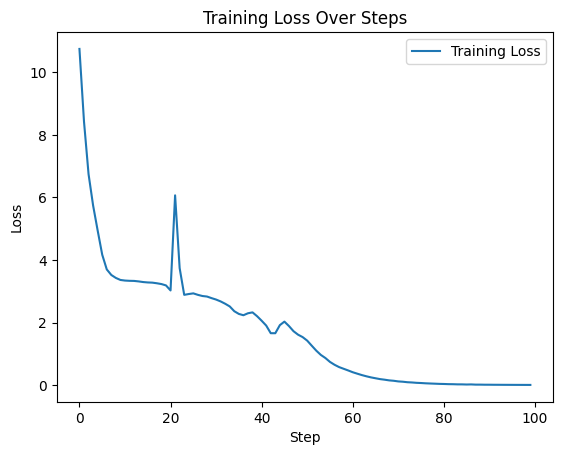

In [93]:
import matplotlib.pyplot as plt
# Plotting the loss
plt.plot(losses, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Steps')
plt.legend()
plt.show()